In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pytorch_dataset

import matplotlib.pyplot as plt
import pandas as pd

import albumentations as A

In [26]:
df = pd.read_csv('/Users/user/repos/zoobot-3d/data/gz3d_and_gz_desi_matches.csv')[:100]

# temp, until I update master df
df['segmap_json_loc'] = df['local_gz3d_fits_loc'].str.replace('/fits_gz/', '/segmaps/', regex=False).str.replace('.fits.gz', '.json', regex=False)
df['local_desi_jpg_loc'] = df.apply(lambda x: f'data/desi/jpg/{x["brickid"]}/{x["brickid"]}_{x["objid"]}.jpg', axis=1)


In [27]:
df.columns.values

array(['ra_manga', 'dec_manga', 'mangaid', 'iauname', 'ifudesignsize',
       'manga_tileid', 'nsa_id', 'explorer_link',
       'gz_total_classifications', 'gz_bar_votes', 'gz_spiral_votes',
       'sample', 'local_gz3d_fits_loc', 'best_match', 'sky_separation',
       'ra_desi', 'dec_desi', 'brickid', 'objid', 'dr8_id', 'mag_r',
       'mag_g', 'mag_z', 'est_dr5_pixscale', 'segmap_json_loc',
       'local_desi_jpg_loc'], dtype=object)

In [30]:
gz_desi = pd.read_parquet('/Users/user/Downloads/gz_desi_deep_learning_catalog_friendly.parquet',
                          columns=[
                              'dr8_id',
                              'smooth-or-featured_featured-or-disk_fraction',
                              'has-spiral-arms_yes_fraction',
                              'spiral-arm-count_2_fraction'
                            ])

In [31]:
gz_desi = gz_desi[gz_desi['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
gz_desi = gz_desi[gz_desi['has-spiral-arms_yes_fraction'] > 0.5]
gz_desi = gz_desi[gz_desi['spiral-arm-count_2_fraction'] > 0.3]

In [32]:

df = pd.merge(df, gz_desi, on='dr8_id', validate='one_to_one', how='inner')

In [35]:
len(df)

7

In [33]:
transform = A.Compose(
    [
        A.CenterCrop(250, 250)
    ],
    additional_targets={'spiral_mask': 'image', 'bar_mask': 'image'}
)
# transform = None

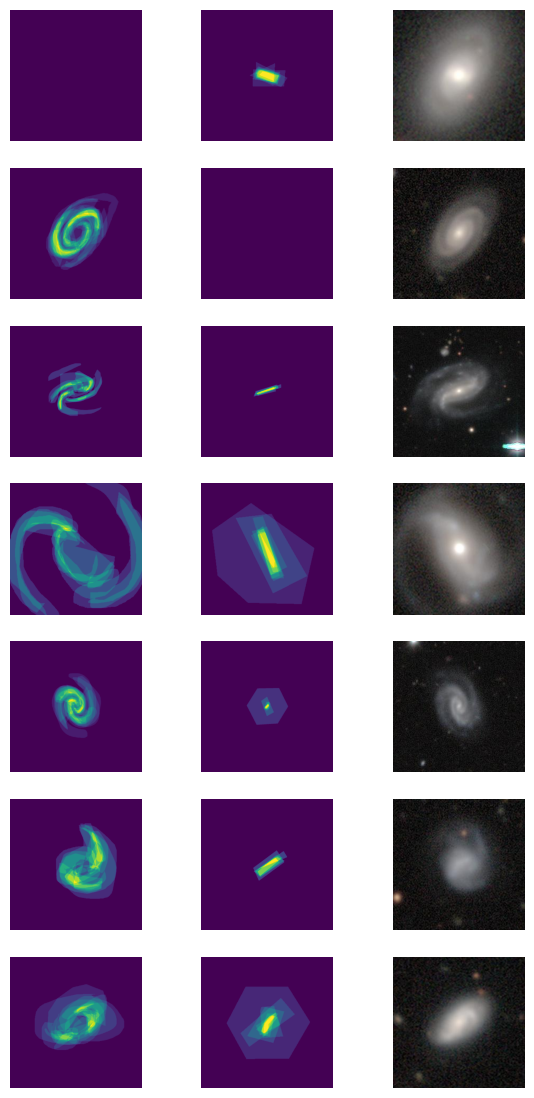

In [36]:
n_examples = 7

dataset = pytorch_dataset.SegmentationGalaxyDataset(df.sample(n_examples), transform=transform)

fig, rows = plt.subplots(ncols=3, nrows=n_examples, figsize=(7, 2*n_examples))


for galaxy_n in range(n_examples):

    (ax0, ax1, ax2) = rows[galaxy_n]

    image, segmap_dict = dataset[galaxy_n]
   
    ax0.imshow(segmap_dict['spiral_mask'])
    ax1.imshow(segmap_dict['bar_mask'])
    ax2.imshow(image)  # default target keyed as image
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')

plt.show()